# Read and process eddy covariance raw data

In [30]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import datetime as dt
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys
import pickle
import os

# import plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

In [2]:
# ------------------------------------------------------------------------------------------
# Directory Lists

# Find host name
import socket
if socket.gethostname().find('.')>=0:
    name=socket.gethostname()
else:
    name=socket.gethostbyaddr(socket.gethostname())[0]

# Determine which machine the script is running on; set up directory names
if 'btgmm8' in name:
    dirPre = '/Users/karllapo/Desktop/proj/VertHarpExp2017Kloendeel/'
elif 'klapos' in name:
    dirPre = '/Users/karllapo/gdrive/DarkMix/proj/VertHarpExp2017Kloendeel/'

dirData = dirPre + 'data/land_station_eddycovar_2m/'
dirPrint = dirPre + 'graphics'
dirProcessed = dirPre + 'data/land_station_eddycovar_2m_processed/'

In [27]:
# Date parsing function for reading the data csv's
# In pandas v.21.0 the below lambda function works. But, we have to downgrade due to an error in
# representing datetimes in that version.
# parse = lambda x : dt.datetime.strptime(x, '%Y %m %d %H %M %S %f')

def parse(Y, m, d, H, M, S, f):
    dateList = [Y, m, d, H, M, S, f]
    return(dt.datetime.strptime(' '.join(dateList), '%Y %m %d %H %M %S %f'))

# In order to keep bmmflux from crashing I had to break the analyis up into
# chunks. Each chunk is labeled according to the time period (DOY) that it covers.
# mThis also applies to the commented line in the read_csv.
DOY = ['247', '247_5', '248', '248_5']
os.chdir(dirData)
csvFileList = []

for day in DOY:
    os.chdir(dirData + 'DOY' + day)
    dirContents = os.listdir()
    for file in dirContents:
        if '.csv.gz' in file:
            print('Working on: ' + file)
            
            # Read the csv
            f = pd.read_csv(file, skiprows=[0, 1], delimiter=',',\
#                             header=[2],
#                             parse_dates={'time': ['#year#', '#MM#', '#DD#', '#hh#', '#min#', '#sec#', '#msec#']},
                            parse_dates=[[0, 1, 2, 3, 4, 5, 6]],
                            index_col=0, date_parser=parse)
            
            # Append to list of all pandas Dataframes
            csvFileList.append(f)

# Concatenate all files along the time dimension
sonic_2m = pd.concat(csvFileList)
sonic_2m.index.names = ['time']


Working on: ExpMM2017_land_20172470000.csv.gz
Working on: ExpMM2017_land_20172470100.csv.gz
Working on: ExpMM2017_land_20172470200.csv.gz
Working on: ExpMM2017_land_20172470300.csv.gz
Working on: ExpMM2017_land_20172470400.csv.gz
Working on: ExpMM2017_land_20172470500.csv.gz
Working on: ExpMM2017_land_20172470600.csv.gz
Working on: ExpMM2017_land_20172470700.csv.gz
Working on: ExpMM2017_land_20172470800.csv.gz
Working on: ExpMM2017_land_20172470900.csv.gz
Working on: ExpMM2017_land_20172471000.csv.gz
Working on: ExpMM2017_land_20172471100.csv.gz
Working on: ExpMM2017_land_20172471200.csv.gz
Working on: ExpMM2017_land_20172471300.csv.gz
Working on: ExpMM2017_land_20172471400.csv.gz
Working on: ExpMM2017_land_20172471500.csv.gz
Working on: ExpMM2017_land_20172471600.csv.gz
Working on: ExpMM2017_land_20172471700.csv.gz
Working on: ExpMM2017_land_20172471800.csv.gz
Working on: ExpMM2017_land_20172471900.csv.gz
Working on: ExpMM2017_land_20172472000.csv.gz
Working on: ExpMM2017_land_2017247

In [28]:
print(sonic_2m)

                         S1_Ux  S1_Uy  S1_Uz  S1_Ts  S1_diag_sonic  S2_Ux  \
time                                                                        
2017-09-04 00:00:00.500  0.794 -0.306 -0.039  12.74           40.0  1.077   
2017-09-04 00:00:00.100  0.793 -0.313 -0.059  12.73           41.0  1.077   
2017-09-04 00:00:00.150  0.780 -0.327 -0.046  12.69           42.0  1.055   
2017-09-04 00:00:00.200  0.697 -0.405 -0.065  12.61           43.0  1.038   
2017-09-04 00:00:00.250  0.698 -0.434 -0.027  12.70           44.0  1.093   
2017-09-04 00:00:00.300  0.689 -0.416  0.003  12.73           45.0  1.046   
2017-09-04 00:00:00.350  0.688 -0.363 -0.003  12.75           46.0  1.099   
2017-09-04 00:00:00.400  0.667 -0.376 -0.040  12.71           47.0  1.094   
2017-09-04 00:00:00.450  0.696 -0.356 -0.042  12.70           48.0  1.100   
2017-09-04 00:00:00.500  0.665 -0.379 -0.030  12.64           49.0  1.028   
2017-09-04 00:00:00.550  0.699 -0.390 -0.036  12.62           50.0  1.040   

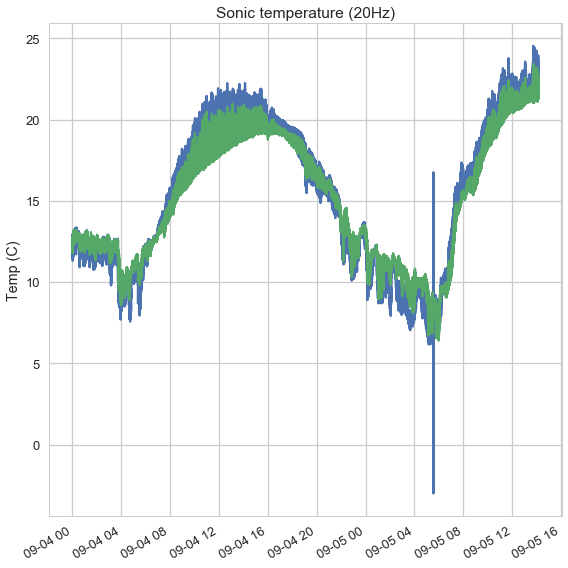

In [31]:
plotFlag = True
if plotFlag:
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.plot(sonic_2m.index, sonic_2m.S1_Ts)
    ax.plot(sonic_2m.index, sonic_2m.S2_Ts)
    ax.set_ylabel('Temp (C)')
    ax.set_title('Sonic temperature (20Hz)')
    fig.autofmt_xdate()
    fig.tight_layout()

## Format results

In [33]:
# Remove duplicate time steps
sonic_2m = sonic_2m[~sonic_2m.index.duplicated(keep='first')]

# Convert to xarray Dataset
sonic_2m.rename({'index': 'time'}, inplace=True)
sonic_2m = xr.Dataset.from_dataframe(sonic_2m)
print(sonic_2m)

# save to a netcdf file
os.chdir(dirProcessed)
sonic_2m.to_netcdf('VHRSE.eddyCovarObs_2m_land.Raw.nc')


<xarray.Dataset>
Dimensions:        (time: 2607811)
Coordinates:
  * time           (time) datetime64[ns] 2017-09-04T00:00:00.500000 ...
Data variables:
    S1_Ux          (time) float64 0.794 0.793 0.78 0.697 0.698 0.689 0.688 ...
    S1_Uy          (time) float64 -0.306 -0.313 -0.327 -0.405 -0.434 -0.416 ...
    S1_Uz          (time) float64 -0.039 -0.059 -0.046 -0.065 -0.027 0.003 ...
    S1_Ts          (time) float64 12.74 12.73 12.69 12.61 12.7 12.73 12.75 ...
    S1_diag_sonic  (time) float64 40.0 41.0 42.0 43.0 44.0 45.0 46.0 47.0 ...
    S2_Ux          (time) float64 1.077 1.077 1.055 1.038 1.093 1.046 1.099 ...
    S2_Uy          (time) float64 -0.422 -0.407 -0.442 -0.438 -0.434 -0.421 ...
    S2_Uz          (time) float64 0.068 0.066 0.06 0.077 0.065 0.018 0.033 ...
    S2_Ts          (time) float64 12.68 12.69 12.65 12.69 12.66 12.66 12.68 ...
    S2_diag_sonic  (time) float64 38.0 39.0 40.0 41.0 42.0 43.0 44.0 45.0 ...
    co2_mmol_m3    (time) float64 32.37 32.21 32.28 32.

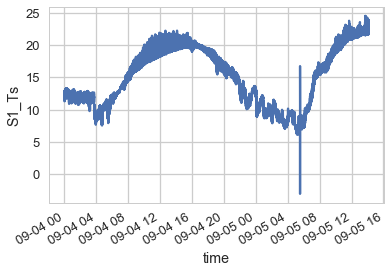

In [36]:
# Timestamps now make the round trip when not using v0.21 of pandas
test = xr.open_dataset('VHRSE.eddyCovarObs_2m_land.Raw.nc')
test.S1_Ts.plot()